In [35]:
import pandas as pd

In [36]:
df = pd.read_csv('data/movies_overview.csv')
df.head()

,title,overview,genre_ids
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]"
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[18, 80]"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]"
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]"
4,12 Angry Men,The defense and the prosecution have rested an...,[18]


# EDA

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9980 entries, 0 to 9979
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      9980 non-null   object
 1   overview   9980 non-null   object
 2   genre_ids  9980 non-null   object
dtypes: object(3)
memory usage: 234.0+ KB


In [38]:
df["genre_ids"].value_counts()

genre_ids
[18]                        577
[35]                        571
[18, 10749]                 273
[35, 10749]                 246
[35, 18]                    232
                           ... 
[35, 27, 878, 53]             1
[10749, 35, 18, 14]           1
[80, 53, 9648, 28]            1
[28, 10752, 12, 36, 18]       1
[878, 28, 35, 10770, 27]      1
Name: count, Length: 2222, dtype: int64

In [39]:
from ast import literal_eval
from itertools import chain
from collections import Counter

df_genres = df.copy()

genre_list_id = list(chain.from_iterable(df["genre_ids"].apply(literal_eval)))

id_name_map = pd.read_csv('data/movies_genres.csv').to_dict(orient='records')
id_name_map = {item['id']: item['name'] for item in id_name_map}

genre_list = [id_name_map[genre_id] for genre_id in genre_list_id if genre_id in id_name_map]

genre_counter = Counter(genre_list)

genre_counter

Counter({'Drama': 4523,
         'Comedy': 3626,
         'Thriller': 2757,
         'Action': 2349,
         'Adventure': 1700,
         'Romance': 1699,
         'Crime': 1573,
         'Horror': 1475,
         'Science Fiction': 1235,
         'Fantasy': 1154,
         'Family': 1134,
         'Mystery': 966,
         'Animation': 910,
         'History': 490,
         'War': 324,
         'Music': 279,
         'Western': 152,
         'TV Movie': 119})

In [40]:
from pprint import pprint

pprint(id_name_map)
pprint(df[["overview", "genre_ids"]].sample(5).to_dict(orient='records'))

{12: 'Adventure',
 14: 'Fantasy',
 16: 'Animation',
 18: 'Drama',
 27: 'Horror',
 28: 'Action',
 35: 'Comedy',
 36: 'History',
 37: 'Western',
 53: 'Thriller',
 80: 'Crime',
 99: 'Documentary',
 878: 'Science Fiction',
 9648: 'Mystery',
 10402: 'Music',
 10749: 'Romance',
 10751: 'Family',
 10752: 'War',
 10770: 'TV Movie'}
[{'genre_ids': '[80, 53, 18]',
  'overview': 'In 1940s Los Angeles, two former boxers-turned-cops must '
              'grapple with corruption, narcissism, stag films and family '
              'madness as they pursue the killer of an aspiring young '
              'actress.'},
 {'genre_ids': '[28, 18, 10752]',
  'overview': 'At the end of World War II, a German soldier is looking for his '
              'daughter while an SS troop is looking for a Jewish treasure.'},
 {'genre_ids': '[18, 35]',
  'overview': 'A dark comedy centering on the lives of a Neapolitan based '
              'family whose father, a fish merchant, is so infatuated with the '
              'r

In [41]:
import re

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)


df["overview"] = df["overview"].apply(remove_punctuation)
df["overview"] = df["overview"].apply(remove_extra_spaces)

In [42]:
import plotly.graph_objects as go

word_count = df["overview"].str.split().str.len()

fig = go.Figure(data=[go.Histogram(x=word_count)])

fig.update_layout(
    title="Distribution of Word Count in Movie Overviews",
    xaxis_title="Word Count",
    yaxis_title="Frequency",
    xaxis=dict(
        tickmode='linear',
        dtick=1,
        range=[0, 100]
    )
)
fig.show()

In [43]:
from collections import Counter

def most_frequent_words(texts, n=10):
    words = [word for txt in texts for word in txt.split()]

    word_counts = Counter(words)

    most_common = dict(word_counts.most_common(n))

    fig = go.Figure(
        go.Bar(
            x=list(most_common.keys()),
            y=list(most_common.values())
        )
    )
    fig.update_layout(
        title_text=f"Top {n} most frequent words in the text",
        title_x=0.5,  # Center the title
        xaxis_title="Words",
        yaxis_title="Frequency",
        xaxis_tickangle=-45,
    )
    fig.show()
most_frequent_words(df["overview"], 40)


# Preprocessing

In [44]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

list(stop_words)[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['than', 'while', 'of', "hasn't", 'a', 'few', "we've", 'where', 'isn', 'him']

In [45]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 4.2 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 4.8 MB/s eta 0:00:03
     --------- ------------------------------ 2.9/12.8 MB 4.8 MB/s eta 0:00:03
     ------------ --------------------------- 3.9/12.8 MB 4.8 MB/s eta 0:00:02
     --------------- ------------------------ 5.0/12.8 MB 4.8 MB/s eta 0:00:02
     ------------------ --------------------- 6.0/12.8 MB 4.8 MB/s eta 0:00:02
     --------------------- ------------------ 6.8/12.8 MB 4.7 MB/s eta 0:00:02
     ------------------------ --------------- 7.9/12.8 MB 4.7 MB/s eta 0:00:02
     --------------------------- ------------ 8.9/12.8 MB 4.7 MB/s eta 0:00:01
     ------------------------------- -------- 10.0/12.8 MB 4.7 MB/s eta 0:00:01
     ---------------------------------- ----- 11.0/12.8 MB 4.7 MB/s eta 0:00:01
     ------------------------------------- -- 12.1/12.8 M

In [46]:
import spacy

nlp = spacy.load("en_core_web_sm")

stop_words_spacy = nlp.Defaults.stop_words

list(stop_words_spacy)[:10]

['of',
 '‘d',
 'someone',
 'a',
 'where',
 'before',
 'already',
 '‘re',
 'next',
 'our']

In [47]:
titulos_duplicados = df[df.duplicated(subset=['title'], keep=False)]
titulos_duplicados = titulos_duplicados.sort_values('title')
print(titulos_duplicados)

                  title                                           overview  \
4          12 Angry Men  The defense and the prosecution have rested an...   
916        12 Angry Men  During the trial of a man accused of his fathe...   
2427       3:10 to Yuma  In Arizona in the late 1800s infamous outlaw B...   
2362       3:10 to Yuma  Dan Evans a small time farmer is hired to esco...   
1474  A Christmas Carol  Miser Ebenezer Scrooge is awakened on Christma...   
...                 ...                                                ...   
8098         Wrong Turn  Jen and a group of friends set out to hike the...   
592                   Z  Amid a tense political climate the opposition ...   
5262                  Z  A family find themselves terrorized by their e...   
4879               Zulu  As a child Ali Neuman narrowly escaped being m...   
1695               Zulu  In 1879 during the AngloZulu War manofthepeopl...   

                   genre_ids  
4                       [18]  
9

In [48]:
#as duplicatas correspondiam a menos de 5% do dataset, decidi removê-las
df_clean = df.drop_duplicates(subset=['title'])
df_clean = df_clean.drop_duplicates(subset=['overview'])
df_clean

,title,overview,genre_ids
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]"
1,The Godfather,Spanning the years 1945 to 1955 a chronicle of...,"[18, 80]"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]"
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]"
4,12 Angry Men,The defense and the prosecution have rested an...,[18]
...,...,...,...
9974,Super Mario Bros.,Mario and Luigi plumbers from Brooklyn find th...,"[12, 14, 35, 10751, 878]"
9975,Double Dragon,Two brothers have half of a powerful ancient C...,"[28, 12, 35, 14, 878]"
9976,The Fanatic,A rabid film fan stalks his favorite action he...,"[80, 53]"
9977,SPF-18,18yearold Penny Cooper spent years pining for ...,"[10749, 18]"


In [ ]:
import ast
import re

def parse_genre_ids_alternative(x):
    if pd.isnull(x):
        return []
    ids = re.findall(r'\d+', str(x))
    return [id_name_map[int(id)] for id in ids if int(id) in id_name_map]

df_clean['genres'] = df_clean['genre_ids'].apply(parse_genre_ids_alternative)

df_clean

,title,overview,genre_ids,genres
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]","[Drama, Crime]"
1,The Godfather,Spanning the years 1945 to 1955 a chronicle of...,"[18, 80]","[Drama, Crime]"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]","[Drama, Crime]"
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]","[Drama, History, War]"
4,12 Angry Men,The defense and the prosecution have rested an...,[18],[Drama]
...,...,...,...,...
9974,Super Mario Bros.,Mario and Luigi plumbers from Brooklyn find th...,"[12, 14, 35, 10751, 878]","[Adventure, Fantasy, Comedy, Family, Science F..."
9975,Double Dragon,Two brothers have half of a powerful ancient C...,"[28, 12, 35, 14, 878]","[Action, Adventure, Comedy, Fantasy, Science F..."
9976,The Fanatic,A rabid film fan stalks his favorite action he...,"[80, 53]","[Crime, Thriller]"
9977,SPF-18,18yearold Penny Cooper spent years pining for ...,"[10749, 18]","[Romance, Drama]"


In [50]:
!pip install matplotlib

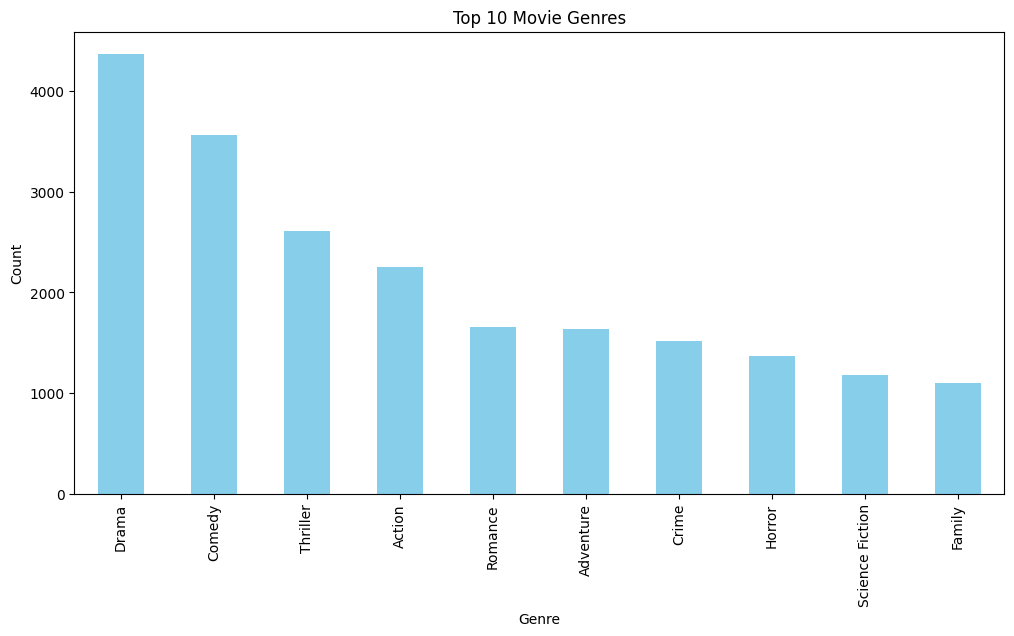

In [ ]:
import matplotlib.pyplot as plt


all_genres = [genre for sublist in df_clean['genres'] for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 6))
genre_counts.head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df_clean['cleaned_overview'] = df_clean['overview'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump

# criar vetorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english'
)

# aplicar TF-IDF aos textos pré-processados
X = tfidf.fit_transform(df_clean['cleaned_overview'])

dump(tfidf, 'models/tfidf_vectorizer.pkl')


['models/tfidf_vectorizer.pkl']

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# binarizando os gêneros
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_clean['genres'])

dump(mlb, 'models/label_encoder.pkl')

# gêneros disponíveis
print("Gêneros disponíveis:", mlb.classes_)

Gêneros disponíveis: ['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Drama' 'Family'
 'Fantasy' 'History' 'Horror' 'Music' 'Mystery' 'Romance'
 'Science Fiction' 'TV Movie' 'Thriller' 'War' 'Western']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, hamming_loss

# modelo one vs rest
lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
lr_model.fit(X_train, y_train)

dump(lr_model, 'models/genre_classifier.pkl')

# previsões
y_pred = lr_model.predict(X_test)

# avaliação do modelo
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))
print("Hamming Loss:", hamming_loss(y_test, y_pred))

Relatório de Classificação:
                  precision    recall  f1-score   support

         Action       0.85      0.37      0.51       449
      Adventure       0.82      0.14      0.24       350
      Animation       1.00      0.04      0.08       173
         Comedy       0.74      0.45      0.56       711
          Crime       0.84      0.26      0.39       295
          Drama       0.72      0.60      0.66       880
         Family       0.91      0.09      0.17       216
        Fantasy       0.78      0.06      0.11       244
        History       1.00      0.01      0.02        96
         Horror       0.92      0.11      0.20       287
          Music       0.00      0.00      0.00        57
        Mystery       0.71      0.03      0.05       177
        Romance       0.81      0.21      0.33       326
Science Fiction       0.96      0.20      0.32       256
       TV Movie       0.00      0.00      0.00        22
       Thriller       0.73      0.30      0.42       525
 

c:\Users\marie\OneDrive\Área de Trabalho\nlp-genre-classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\marie\OneDrive\Área de Trabalho\nlp-genre-classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

c:\Users\marie\OneDrive\Área de Trabalho\nlp-genre-classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.

c:\Users\marie\OneDrive\Área de Trabalho\nlp-genre-classification\.venv\Lib\site-packages\sklearn\metrics\_classificatio